# つくりながら学ぶ！深層強化学習 PyTorchによる実践プログラミング

## 迷路問題

前回は、方策反復法の具体的アルゴリズムである 方策勾配法 (Policy Gradient Method) を実装した

今回は価値反復法の実装を行う

### 報酬
価値反復法を実行するには価値を定義する必要がある

強化学習においては、価値を定義するために **報酬** という概念を用いる

迷路問題の場合はゴールをしたときに報酬を与えるが、ロボットの歩行などの場合は、転ばずに歩けている間毎ステップ報酬を与える

この、とある時刻 $t$ でもらえる報酬 $R_t$ を **即時報酬 (Immediate Reward)** と呼ぶ

また、今後未来にわたって得られるであろう報酬の合計 $G_t$ を **報酬和** と呼ぶ

$$
    G_t = R_{t+1} + R_{t+2} + \cdots
$$

### 行動価値と状態価値
報酬を定義できたら価値を定義する

価値反復法では **行動価値 (Action Value)** と **状態価値 (State Value)** という2つの価値を定義する

以下の迷路問題を例に2つの価値について考える

```
┌--------------┐
| S0   S1   S2 |
|     ----┐    |
| S3   S4 | S5 |
|         └----|
| S6 | S7   S8 |
└--------------┘
```

ゴールである状態 S8 にエージェントが辿り着いたら報酬 $R_{t+1} = 1$ がもらえると設定する

#### 行動価値
現在エージェントが S7 にいると仮定すると、右に移動すればゴールに辿り着くことができる

つまり状態 $s = S7$ で行動 $a = 右$ だった場合、報酬 $R_{t+1} = 1$ を手にすることができる

これを式で表すために、行動価値を行動価値関数 $Q^\pi (s, a)$ を導入する

行動 $a$ を (上: 0, 右: 1, 下: 2, 左: 3) で表すと、以下のような式で表すことができる

$$
    Q^\pi (s = 7, a = 1) = R_{t+1} = 1
$$

次に、エージェントが状態 $s = S7$ において行動 $a = 上 = 0$ をとった場合を考える

この場合エージェントは S7 から S4 へ移動してゴールから遠ざかるため、ゴールまでのステップは S7 → S4 → S7 → S8 となり、2ステップ余分にかかるようになる

これを式で表すために、割引率 $\gamma$ (0 < $\gamma$ < 1) を導入する

1ステップ時間がかかる度に、本来の報酬から $\gamma$ 分割引されると考えると、2ステップ余分な時間がかかる S7 → S4 への移動は以下の式で表すことができる

$$
    Q^\pi (s = 7, a = 0) = R_{t+1} = \gamma^2 * 1
$$

#### 状態価値
状態価値とは、状態 $s$ において方策 $\pi$ に従って行動することで、その後将来にわたって得られることが期待される割引報酬和 $G_t$ である

状態 $s$ における状態価値関数を $V^\pi (s)$ と表記する

例えば、エージェントが S7 にいる場合に右に移動すればゴールして報酬 1 を得ることができるため、以下のように表すことができる

$$
    V^\pi (s = 7) = 1
$$

なおこのとき、方策 $\pi$ は常に最短経路を目指すものであると仮定する

従って、エージェントが S4 にいる場合は、S4 → S7 → S8 が最短経路であり、1ステップ余分な時間がかかるため、

$$
    V^\pi (s = 4) = \gamma * 1
$$

となる

エージェントが S4 にいる場合の状態価値関数は、S7 での状態価値関数を用いて以下のように表現することもできる

$$
    V^\pi (s = 4) = R_{t+1} + \gamma * V^\pi (s = 7)
$$

ここで $R_{t+1}$ は状態 S7 になった場合に得られる即時報酬だが、今回の場合ゴールに辿り着いた場合以外に報酬は得られないため $R_{t+1} = 0$ となる

つまり、

$$
    V^\pi (s = 4) = 0 + \gamma * V^\pi (s = 7) = \gamma * 1 = \gamma
$$

となる

### ベルマン方程式とマルコフ決定過程
状態価値関数をより一般的な式で表すと、以下のような式で表すことができる

$$
    V^\pi (s) = \max_a\mathbb{E}[R_{s,a} + \gamma * V^\pi (s(s, a))]
$$

これを **ベルマン方程式** と呼ぶ

- $V^\pi (s)$
    - 状態 $s$ での状態価値 $V$
    - 最大の報酬を得られるように行動 $a$ を採用したときに期待される値となる ($\max_a\mathbb{E}$)
- $R_{s,a}$
    - 状態 $s$ で行動 $a$ を採用したときに得られる即時報酬 $R_{t+1}$
- $s(s, a)$
    - 状態 $s$ で行動 $a$ を採用した後の状態 $s_{t+1}$
- $\gamma$
    - 時間割引率 (0 < $\gamma$ < 1)

ベルマン方程式は「新たな状態 $s_{t+1}$ での状態価値 $V$ に1step分の時間割引率 $\gamma$ を掛けた項と即時報酬 $R_{s,a}$ の和の最大値が現在の状態価値となる」ことを示している

このベルマン方程式は、行動価値についても同様の式が成り立つ

ベルマン方程式が成り立つための前提条件として、学習対象が **マルコフ決定過程** である必要がある

マルコフ決定過程とは「次のステップの状態 $s_{t+1}$ が現在の状態 $s_t$ と採用した行動 $a_t$ で決定されるシステム」を意味する

つまり、次の状態が現在の状態と行動によってのみ決定され、その他の要因（例えば更に前の行動や状態）に影響を受けないことが前提となる

## Sarsa の実装

ここでは、価値反復法のアルゴリズムである Sarsa を実装する

まずは、行動価値関数 $Q(s,a)$ を表形式 (行: 状態, 列: 行動) で実装する

初期の行動価値では、正しい値は分からない (正しい価値を強化学習で学習する) ため、最初はランダムな値を与えておく

In [1]:
using Revise

include("01_02-maze_module.jl")

# 初期方策パラメータ θ_0
theta_0 = Maze.theta_0

8×4 Matrix{Float64}:
 NaN      1.0    1.0  NaN
 NaN      1.0  NaN      1.0
 NaN      1.0    1.0    1.0
   1.0    1.0    1.0  NaN
 NaN    NaN      1.0    1.0
   1.0  NaN    NaN    NaN
   1.0  NaN    NaN    NaN
   1.0    1.0  NaN    NaN

In [3]:
# 初期行動価値関数 Q: ランダムな値を与える
## rand(M, N): MxN Matrix{Float64} の乱数を生成
## 初期方策パラメータに各値を掛け算することで、壁方向への値を NaN にする
Q = rand(size(theta_0)...) .* theta_0

8×4 Matrix{Float64}:
 NaN           0.524065    0.364797  NaN
 NaN           0.777577  NaN           0.574869
 NaN           0.89256     0.402578    0.329233
   0.961843    0.159176    0.551302  NaN
 NaN         NaN           0.357104    0.59382
   0.682664  NaN         NaN         NaN
   0.552861  NaN         NaN         NaN
   0.294521    0.791233  NaN         NaN

### ε-greedy法
各時刻で行動 $a$ を行動価値 $Q$ から求める方策を実装する

単純に考えれば $Q$ の値が最大となる行動を採用すれば良く、この作戦を greedy法 と呼ぶ

しかし、正しい $Q$ が決まっていない状態でこの方策を採用すると、ランダム生成した初期 $Q$ の値に応じて行動が確定してしまい、その後うまく学習できない可能性がある（例えば最初の S0 の位置で毎回右に動いてしまうなど）

そこで、一定の確率 $\epsilon$ でランダムに行動し、$1-\epsilon$ の確率で行動価値 $Q$ が最大になる行動を採用する

この作戦を **ε-greedy法** と呼ぶ

この $\epsilon$ 値は試行回数（エピソード数）が増えるに従って小さくするように設定し、学習の進行に応じてランダム行動を少なくしてあげると良い

このように価値反復法の強化学習では、現在の行動価値関数の最大値を利用して行動を決める方法（利用）とランダムに行動させる方法（探査）をうまく混ぜる必要があり、これを **探査と利用のトレードオフ** と呼ぶ

In [4]:
# 初期方策 π_0: 単純な割合計算で θ から算出
pi_0 = Maze.pi_theta(theta_0)

8×4 Matrix{Float64}:
 0.0       0.5       0.5       0.0
 0.0       0.5       0.0       0.5
 0.0       0.333333  0.333333  0.333333
 0.333333  0.333333  0.333333  0.0
 0.0       0.0       0.5       0.5
 1.0       0.0       0.0       0.0
 1.0       0.0       0.0       0.0
 0.5       0.5       0.0       0.0

In [5]:
using Distributions, NaNStatistics

"""
    e_greedy(state::Int, Q::Matrix{Number}, epsilon::Number, pi_n::Matrix{Number})
        = action::Int

ε-greedy法 で行動を決定

- `state::Int`: 現在の状態
    - 1: S0, 2: S1, ..., 9: S8
- `Q::Matrix{Number}`: 行動価値関数
- `epsilon::Number`: ランダム行動確率 (0 < epsilon < 1)
- `pi_n::Matrix{Number}`: 方策 π

# returns

- `action::Int`:
    - 1: 上
    - 2: 右
    - 3: 下
    - 4: 左
"""
e_greedy(state::Int, Q::Matrix, epsilon::Number, pi_n::Matrix) = begin
    actions = 1:4

    # ランダム行動 (現在の状態における方策を行動の重みとする)
    rand() < epsilon && return wsample(actions, pi_n[state, :])

    # 行動価値関数の最大値の行動を採用
    ## nanmaximum(::Vector): NaN値を無視して最大値を取得
    ## findfirst(::Function, ::Vector): 指定関数に一致する配列のインデックスを取得
    max_val_index = findfirst(x -> x === nanmaximum(Q[state, :]), Q[state, :])
    actions[max_val_index]
end

"""
    next_state(state::Int, action::Int) = state_next::Int

現在の状態と採用する行動から次の状態を取得する関数
"""
next_state(state::Int, action::Int) = begin
    # 状態遷移表: 行動 => 状態遷移
    state_map = Dict(
        1 => -3, # 上
        2 => +1, # 右
        3 => +3, # 下
        4 => -1, # 左
    )
    # 次の状態
    state + state_map[action]
end

next_state

### Sarsaによる行動価値関数の更新
行動価値関数 $Q(s,a)$ の正しい値が決まっていれば、ベルマン方程式より以下の式が成り立つ

$$
    Q(s_t, a_t) = R_{t+1} + \gamma Q(s_{t+1}, a_{t+1})
$$

しかし、学習の途中では正しい行動価値関数が決まっていないため、上記の等式は成り立たない

このとき、上式の両辺の差 $R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)$ を **TD誤差 (Temporal different error)** と呼ぶ

このTD誤差が 0 になったときが正しい学習ができたときであるため、$Q$ の更新式は以下のようになる

$$
    \begin{align}
    Q(s_t, a_t) &= Q(s_t, a_t) + \eta * \rm{TD} \\
                &= Q(s_t, a_t) + \eta * (R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t))
    \end{align}
$$

この更新式を Sarsa と呼ぶ（状態 $s_t$、行動 $a_t$、即時報酬 $R$、次の状態 $s_{t+1}$、次の行動 $a_{t+1}$ の頭文字をとって Sarsa）

In [14]:
"""
    sarsa!(Q::Matrix{Number}, state::Int, action::Int, reward::Number, state_next::Int, action_next::Int, eta::Number, gamma::Number)
        = Q::Matrix{Number}

Sarsa による行動価値関数 Q の更新を行う関数
"""
sarsa!(Q::Matrix, state::Int, action::Int, reward::Number, state_next::Int, action_next::Int, eta::Number, gamma::Number) = begin
    if state_next === 9
        # ゴールした場合
        Q[state, action] = Q[state, action] + eta * (reward - Q[state, action])
    else
        Q[state, action] = Q[state, action] + eta * (reward + gamma * Q[state_next, action_next] - Q[state, action])
    end
    Q
end

"""
    sarsa_maze!(Q::Matrix, epsilon::Number, eta::Number, gamma::Number, pi_n::Matrix)
        = state_action_history::Vector{Tuple(state::Int, action::Int)}

迷路を解いて Sarsa で行動関数を更新する関数
"""
sarsa_maze!(Q::Matrix, epsilon::Number, eta::Number, gamma::Number, pi_n::Matrix) = begin
    start, goal = 1, 9
    state = start # 初期状態
    action = NaN  # 初期行動
    state_action_history = Vector{Tuple}() # (状態, 行動) の記録

    # ゴールするまでエージェントを動かす
    while state !== goal
        if isnan(action)
            # ε-greedy法で行動採用
            action = e_greedy(state, Q, epsilon, pi_n)
        end

        # (状態, 行動) 記録
        push!(state_action_history, (state, action))

        # 次の状態を取得
        state_next = next_state(state, action)

        # 報酬と次の行動を決定
        reward = state_next === goal ? 1 : 0
        action_next = state_next === goal ? 0 : e_greedy(state_next, Q, epsilon, pi_n)

        # 価値関数の更新
        sarsa!(Q, state, action, reward, state_next, action_next, eta, gamma)

        # 状態, 行動更新
        state, action = state_next, action_next
    end

    state_action_history
end

sarsa_maze!

In [18]:
"""
Sarsa による強化学習実行
"""

using ProgressMeter

# 初期行動価値
Q = rand(size(theta_0)...) .* theta_0

eta = 0.1 # 学習率
gamma = 0.9 # 時間割引率
epsilon = 0.5 # ε-greedy法の初期ランダム行動確率
v = nanmaximum(Q; dims=2) # 状態ごとの価値の最大値
records = Vector{Tuple}() # (状態価値の変化絶対総和, ゴールまでのステップ数) の記録
max_episode = 100 # 最大エピソード数

@showprogress for _ = 1:max_episode
    # ランダム行動確率を少しずつ小さくする
    epsilon = epsilon / 2

    # 迷路問題を解いて Sarsa で状態価値を更新
    state_action_history = sarsa_maze!(Q, epsilon, eta, gamma, pi_0)

    # 状態価値の変化
    v_next = nanmaximum(Q; dims=2)

    # 学習記録: (状態価値の変化絶対総和, ゴールまでのステップ数)
    push!(records, (sum(abs.(v_next - v)), length(state_action_history)))
end

records

100-element Vector{Tuple}:
 (0.25769550303477734, 30)
 (0.7842022322027724, 88)
 (1.8030394362123778, 378)
 (2.0125868248515335, 156)
 (2.054161857023443, 6)
 (2.0940510366071186, 8)
 (2.128388423179598, 8)
 (2.149562638368377, 4)
 (2.165544253831634, 4)
 (2.1768552420307463, 4)
 (2.1839886959899264, 4)
 (2.1874077157007896, 4)
 (2.18754490410145, 4)
 ⋮
 (1.854676487727882, 4)
 (1.854459703746445, 4)
 (1.8542575060664275, 4)
 (1.854069007314556, 4)
 (1.8538933643049313, 4)
 (1.8537297769396688, 4)
 (1.8535774869889021, 4)
 (1.8534357767763554, 4)
 (1.8533039677934213, 4)
 (1.8531814192617495, 4)
 (1.8530675266617036, 4)
 (1.852961720241677, 4)

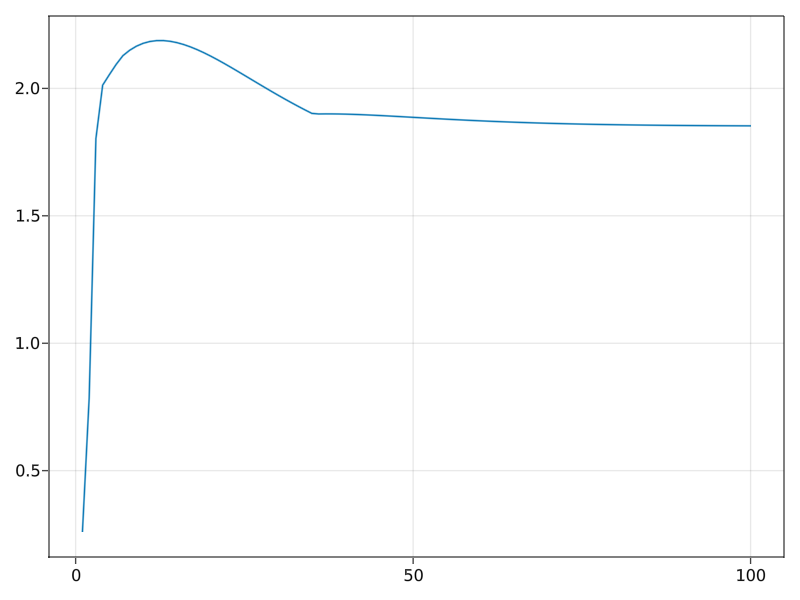

In [19]:
using GLMakie

# 状態価値の変化絶対総和 の記録をプロット
lines(getindex.(records, 1))

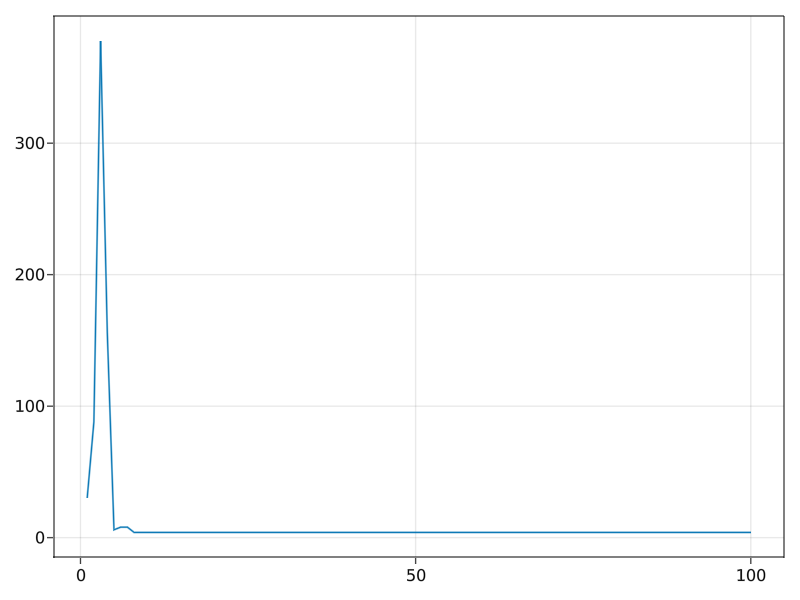

In [20]:
# ゴールまでのステップ数 の記録をプロット
lines(getindex.(records, 2))

上記の通り、価値反復法は行動反復法に比べて以下のような特徴があることが分かる

- より少ない学習回数で行動最適化を行うことができる
- 学習の変化絶対総和はそれほど小さく収束しない

---

[今回の実装モジュール](./01_03-maze_module.jl)

```julia
include("01_03-maze_module.jl")
using .Maze

records, Q = train(theta_0)
save_anim("01_03-maze.gif", records[end][2])
```